## Mount G-Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Import Libraries and Files

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
df=pd.read_excel('../content/gdrive/MyDrive/DadosPWFTS/DadosNormaisDeep.xlsx')
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (4206, 5)


,LIT_2012KS_0251_FilteredSignal,_AL_2012KS_06M1_SpeedActual,WIT_1085KS_2300_BeltLoad,WIT_1085KS_2300_Rate,status
0,2.8321,0.0000,295.4968,6383.8877,1.0000
1,4.4181,0.0000,321.6937,6722.2646,1.0000
2,22.9539,14.7619,337.2798,7027.4663,1.0000
3,33.8160,71.4544,426.3976,8533.0020,1.0000
4,33.3744,90.9982,511.3877,10280.8340,1.0000


The following data pre-processing and feature engineering steps need to be done:


*   Merge Date & Time into one column and change to datetime type.
*   Convert Global_active_power to numeric and remove missing values (1.2%).
*   Create year, quarter, month and day features.
*   Create weekday feature, “0” is weekend and “1” is weekday.




  
  
  

In [4]:
#df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['LIT_2012KS_0251_FilteredSignal'] = pd.to_numeric(df['LIT_2012KS_0251_FilteredSignal'], errors='coerce')
df = df.dropna(subset=['LIT_2012KS_0251_FilteredSignal'])
#df['date_time']=pd.to_datetime(df['date_time']) 
#df['year'] = df['date_time'].apply(lambda x: x.year)
#df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
#df['month'] = df['date_time'].apply(lambda x: x.month)
#df['day'] = df['date_time'].apply(lambda x: x.day)
df=df.loc[:,['LIT_2012KS_0251_FilteredSignal','_AL_2012KS_06M1_SpeedActual', 'WIT_1085KS_2300_BeltLoad','WIT_1085KS_2300_Rate','status']]
#df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)
#df["weekday"]=df.apply(lambda row: row["date_time"].weekday(),axis=1)
#df["weekday"] = (df["weekday"] < 5).astype(int)
print('Number of rows and columns after removing missing values:', df.shape)
#print('The time series starts from: ', df.date_time.min())
#print('The time series ends on: ', df.date_time.max())

Number of rows and columns after removing missing values: (4206, 5)


## Statistical Normality Test
*   p <= alpha: reject H0, not normal.
*   p > alpha: fail to reject H0, normal.



In [6]:
stat, p = stats.normaltest(df.LIT_2012KS_0251_FilteredSignal)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=1643.360, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: -1.091779500156369
Skewness of normal distribution: 0.22862900686037216


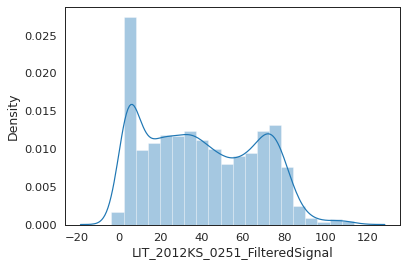

In [8]:
sns.distplot(df.LIT_2012KS_0251_FilteredSignal);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.LIT_2012KS_0251_FilteredSignal)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.LIT_2012KS_0251_FilteredSignal)))

## First Time Series Plot

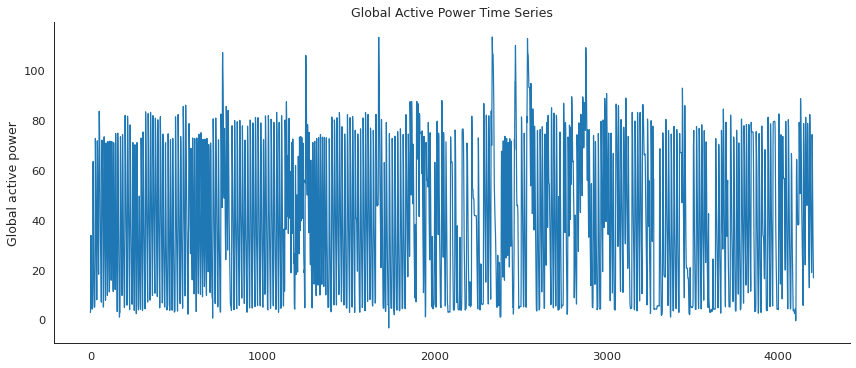

In [9]:
df1=df.loc[:,['LIT_2012KS_0251_FilteredSignal']]
#df1.set_index('date_time',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('Global active power')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Global Active Power Time Series')
sns.despine(top=True)
plt.show();

## Box Plot of Yearly vs. Quarterly Global Active Power

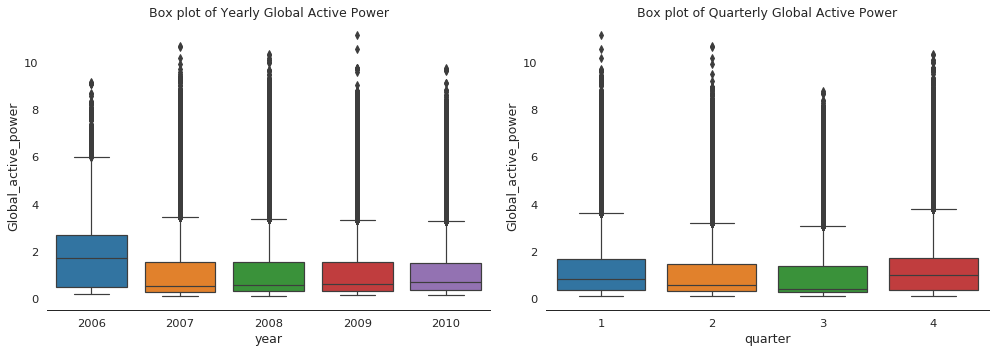

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="Global_active_power", data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly Global Active Power')
sns.despine(left=True)
plt.tight_layout()
plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="Global_active_power", data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Global Active Power')
sns.despine(left=True)
plt.tight_layout();

## Global Active Power Distribution

,count,mean,std,min,25%,50%,75%,max
LIT_2012KS_0251_FilteredSignal,4206.0000,39.9634,26.4276,-3.3357,16.3654,37.5380,63.6473,113.4842


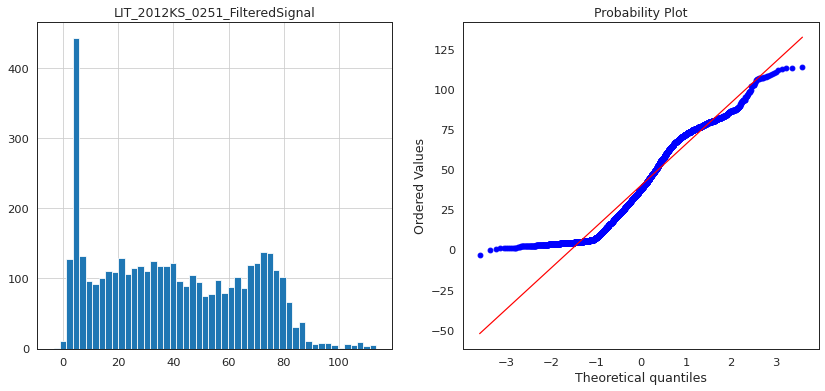

In [10]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['LIT_2012KS_0251_FilteredSignal'].hist(bins=50)
plt.title('LIT_2012KS_0251_FilteredSignal')
plt.subplot(1,2,2)
stats.probplot(df['LIT_2012KS_0251_FilteredSignal'], plot=plt);
df1.describe().T

## Average Global Active Power Resampled Over Day, Week, Month, Quarter and Year

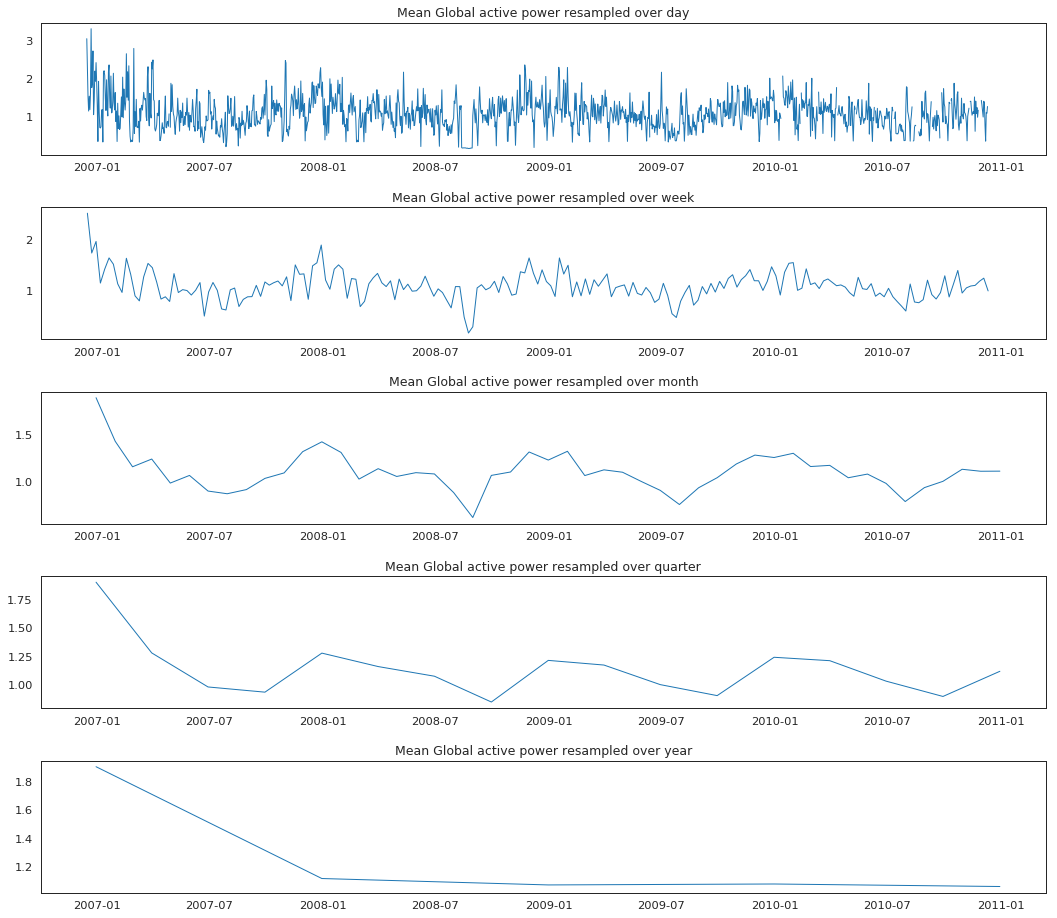

In [ ]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['Global_active_power'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Global active power resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['Global_active_power'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Global active power resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['Global_active_power'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Global active power resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['Global_active_power'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Global active power resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['Global_active_power'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Global active power resampled over year')
ax5.tick_params(axis='both', which='major');

## Plot Mean Global Active Power Grouped by Year, Quarter, Month and Day

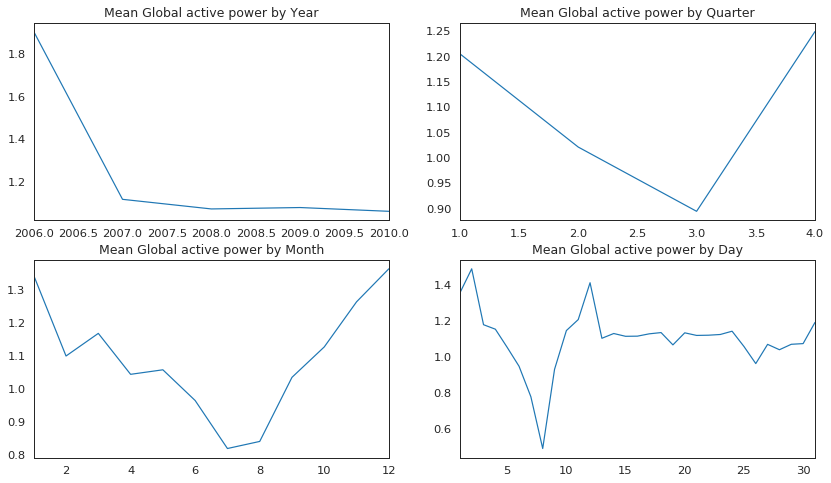

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df.groupby('year').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Year')

plt.subplot(2,2,2)
df.groupby('quarter').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Quarter')

plt.subplot(2,2,3)
df.groupby('month').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Month')

plt.subplot(2,2,4)
df.groupby('day').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Day');

## Global Active Power by Years

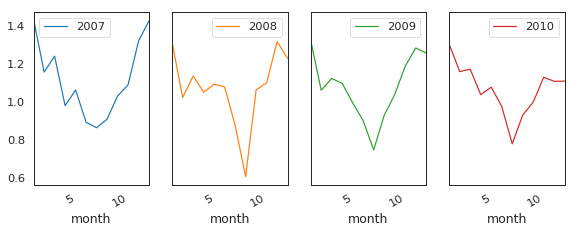

In [ ]:
pd.pivot_table(df.loc[df['year'] != 2006], values = "Global_active_power", 
               columns = "year", index = "month").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True);

## Global Active Power Consumption in Weekdays vs. Weekends

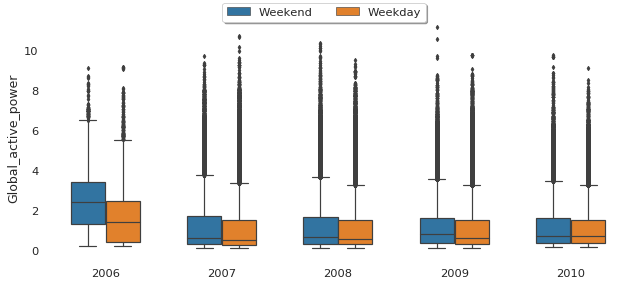

In [ ]:
dic={0:'Weekend',1:'Weekday'}
df['Day'] = df.weekday.map(dic)
a=plt.figure(figsize=(9,4)) 
plt1=sns.boxplot('year','Global_active_power',hue='Day',width=0.6,fliersize=3,
                    data=df)                                                                                                                                                                                                                                                                                                                                                 
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

## Factor Plot of Global Active Power by Weekday vs. Weekend

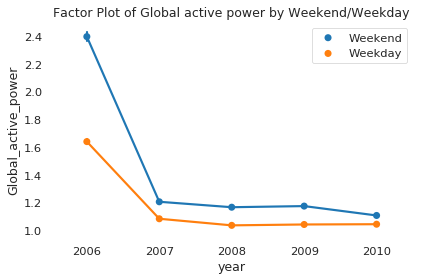

In [ ]:
plt1=sns.factorplot('year','Global_active_power',hue='Day',
                    data=df, size=4, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of Global active power by Weekend/Weekday')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');


## Dickey-Fuller test



*   Null Hypothesis (H0): It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
*   Alternate Hypothesis (H1): It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

*   p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.
*   p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.






In [11]:
df2=df1.resample('D', how=np.mean)

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.LIT_2012KS_0251_FilteredSignal.dropna())

TypeError: ignored

## LSTM



*   The following data pre-processing and feature engineering need to be done before construct the LSTM model.
*   Normalize the features.
*   Split into training and test sets.
*   Convert an array of values into a dataset matrix.
*   Reshape into X=t and Y=t+1.
*   Reshape input to be 3D (num_samples, num_timesteps, num_features).














In [12]:
dataset = df.LIT_2012KS_0251_FilteredSignal.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## Model Architecture



*   Define the LSTM with 100 neurons in the first hidden layer and 1 neuron in the output layer for predicting Global_active_power. The input shape will be 1 time step with 30 features.
*   Dropout 20%.
*   Use the MSE loss function and the efficient Adam version of stochastic gradient descent.
*   The model will be fit for 20 training epochs with a batch size of 70.





In [13]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Epoch 1/20
48/48 [==============================] - 3s 16ms/step - loss: 0.0538 - val_loss: 0.0316
Epoch 2/20
48/48 [==============================] - 0s 5ms/step - loss: 0.0280 - val_loss: 0.0219
Epoch 3/20
48/48 [==============================] - 0s 5ms/step - loss: 0.0210 - val_loss: 0.0164
Epoch 4/20
48/48 [==============================] - 0s 5ms/step - loss: 0.0169 - val_loss: 0.0133
Epoch 5/20
48/48 [==============================] - 0s 5ms/step - loss: 0.0144 - val_loss: 0.0116
Epoch 6/20
48/48 [==============================] - 0s 5ms/step - loss: 0.0125 - val_loss: 0.0104
Epoch 7/20
48/48 [==============================] - 0s 5ms/step - loss: 0.0113 - val_loss: 0.0094
Epoch 8/20
48/48 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0087
Epoch 9/20
48/48 [==============================] - 0s 5ms/step - loss: 0.0099 - val_loss: 0.0081
Epoch 10/20
48/48 [==============================] - 0s 5ms/step - loss: 0.0094 - val_loss: 0.0077
Epoch 11/20
48/48 

## Make Predictions

In [14]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 5.98271466178804
Train Root Mean Squared Error: 9.192844324870036
Test Mean Absolute Error: 6.068884523695372
Test Root Mean Squared Error: 9.050406493707424


## Plot Model Loss

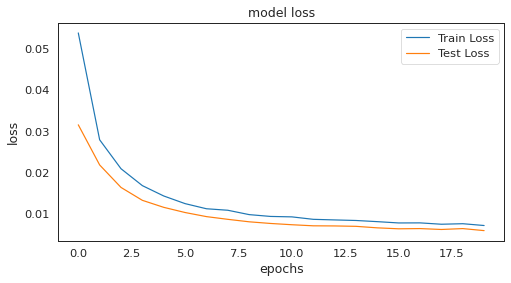

In [15]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

## Compare Actual vs. Prediction

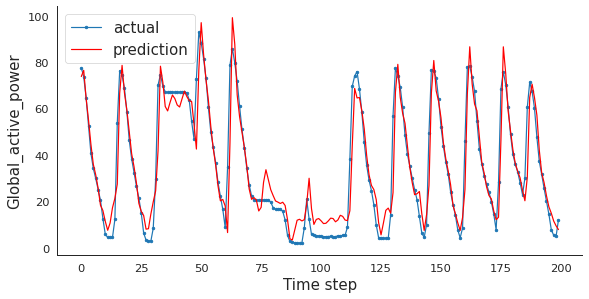

In [16]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();